In [14]:
import os
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from src.CV_IO_utils import read_imgs_dir
from src.CV_transform_utils import apply_transformer
from src.CV_transform_utils import resize_img, normalize_img
from src.CV_plot_utils import plot_query_retrieval, plot_tsne, plot_reconstructions
from src.autoencoder import AutoEncoder

import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Run mode: (autoencoder -> simpleAE, convAE) or (transfer learning -> vgg19)
modelName = "convAE"  # try: "simpleAE", "convAE", "vgg19"
trainModel = True
parallel = True  # use multicore processing

In [4]:
# Make paths
dataTrainDir = os.path.join(os.getcwd(), "data", "train")
dataTestDir = os.path.join(os.getcwd(), "data", "test")
outDir = os.path.join(os.getcwd(), "output", modelName)
if not os.path.exists(outDir):
    os.makedirs(outDir)

In [5]:
# Read images
extensions = [".jpg", ".jpeg"]
print("Reading train images from '{}'...".format(dataTrainDir))
imgs_train = read_imgs_dir(dataTrainDir, extensions, parallel=parallel)
print("Reading test images from '{}'...".format(dataTestDir))
imgs_test = read_imgs_dir(dataTestDir, extensions, parallel=parallel)
shape_img = imgs_train[0].shape
print("Image shape = {}".format(shape_img))

Reading train images from '/Users/bandurin/Courses/SimilarImages_with_LSH/artificio/image_retrieval/data/train'...
Reading test images from '/Users/bandurin/Courses/SimilarImages_with_LSH/artificio/image_retrieval/data/test'...
Image shape = (100, 100, 3)


In [6]:
# Build models
if modelName in ["simpleAE", "convAE"]:

    # Set up autoencoder
    info = {
        "shape_img": shape_img,
        "autoencoderFile": os.path.join(outDir, "{}_autoecoder.h5".format(modelName)),
        "encoderFile": os.path.join(outDir, "{}_encoder.h5".format(modelName)),
        "decoderFile": os.path.join(outDir, "{}_decoder.h5".format(modelName)),
    }
    model = AutoEncoder(modelName, info)
    model.set_arch()

    if modelName == "simpleAE":
        shape_img_resize = shape_img
        input_shape_model = (model.encoder.input.shape[1],)
        output_shape_model = (model.encoder.output.shape[1],)
        n_epochs = 300
    elif modelName == "convAE":
        shape_img_resize = shape_img
        input_shape_model = tuple([int(x) for x in model.encoder.input.shape[1:]])
        output_shape_model = tuple([int(x) for x in model.encoder.output.shape[1:]])
        n_epochs = 500
    else:
        raise Exception("Invalid modelName!")

elif modelName in ["vgg19"]:

    # Load pre-trained VGG19 model + higher level layers
    print("Loading VGG19 pre-trained model...")
    model = tf.keras.applications.VGG19(weights='imagenet', include_top=False,
                                        input_shape=shape_img)
    model.summary()

    shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])
    input_shape_model = tuple([int(x) for x in model.input.shape[1:]])
    output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
    n_epochs = None

else:
    raise Exception("Invalid modelName!")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

autoencoder.summary():
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 8)     

In [7]:
# Print some model info
print("input_shape_model = {}".format(input_shape_model))
print("output_shape_model = {}".format(output_shape_model))

input_shape_model = (100, 100, 3)
output_shape_model = (13, 13, 8)


In [8]:
# Apply transformations to all images
class ImageTransformer(object):

    def __init__(self, shape_resize):
        self.shape_resize = shape_resize

    def __call__(self, img):
        img_transformed = resize_img(img, self.shape_resize)
        img_transformed = normalize_img(img_transformed)
        return img_transformed

transformer = ImageTransformer(shape_img_resize)
print("Applying image transformer to training images...")
imgs_train_transformed = apply_transformer(imgs_train, transformer, parallel=parallel)
print("Applying image transformer to test images...")
imgs_test_transformed = apply_transformer(imgs_test, transformer, parallel=parallel)

# Convert images to numpy array
X_train = np.array(imgs_train_transformed).reshape((-1,) + input_shape_model)
X_test = np.array(imgs_test_transformed).reshape((-1,) + input_shape_model)
print(" -> X_train.shape = {}".format(X_train.shape))
print(" -> X_test.shape = {}".format(X_test.shape))


Applying image transformer to training images...
Applying image transformer to test images...
 -> X_train.shape = (36, 100, 100, 3)
 -> X_test.shape = (3, 100, 100, 3)


In [9]:
# Train (if necessary)
if modelName in ["simpleAE", "convAE"]:
    if trainModel:
        model.compile(loss="binary_crossentropy", optimizer="adam")
        model.fit(X_train, n_epochs=n_epochs, batch_size=256)
        model.save_models()
    else:
        model.load_models(loss="binary_crossentropy", optimizer="adam")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 32 samples, validate on 4 samples
Epoch 1/500
32/32 [==============================] - 1s 28ms/sample - loss: 0.6957 - val_loss: 0.6936
Epoch 2/500
32/32 [==============================] - 0s 10ms/sample - loss: 0.6937 - val_loss: 0.6920
Epoch 3/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.6921 - val_loss: 0.6907
Epoch 4/500
32/32 [==============================] - 0s 11ms/sample - loss: 0.6910 - val_loss: 0.6896
Epoch 5/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.6900 - val_loss: 0.6882
Epoch 6/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.6887 - val_loss: 0.6867
Epoch 7/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.6873 - val_loss: 0.6848
Epoch 8/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.6856 - val_loss: 0.6824
Epoch 9/500
32/32 [==============================] -

Epoch 78/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3874 - val_loss: 0.3805
Epoch 79/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3857 - val_loss: 0.3783
Epoch 80/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3843 - val_loss: 0.3794
Epoch 81/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3828 - val_loss: 0.3769
Epoch 82/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3812 - val_loss: 0.3757
Epoch 83/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3797 - val_loss: 0.3760
Epoch 84/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3782 - val_loss: 0.3737
Epoch 85/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3764 - val_loss: 0.3733
Epoch 86/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3748 - val_loss: 0.3716
Epoch 87/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3733

Epoch 158/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3381 - val_loss: 0.3476
Epoch 159/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3378 - val_loss: 0.3475
Epoch 160/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3375 - val_loss: 0.3471
Epoch 161/500
32/32 [==============================] - 0s 10ms/sample - loss: 0.3372 - val_loss: 0.3470
Epoch 162/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3372 - val_loss: 0.3472
Epoch 163/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3372 - val_loss: 0.3469
Epoch 164/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3371 - val_loss: 0.3469
Epoch 165/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3368 - val_loss: 0.3465
Epoch 166/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3365 - val_loss: 0.3464
Epoch 167/500
32/32 [==============================] - 0s 9ms/sample - l

Epoch 238/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3309 - val_loss: 0.3410
Epoch 239/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3309 - val_loss: 0.3413
Epoch 240/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3310 - val_loss: 0.3411
Epoch 241/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3311 - val_loss: 0.3415
Epoch 242/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3312 - val_loss: 0.3411
Epoch 243/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3311 - val_loss: 0.3413
Epoch 244/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3309 - val_loss: 0.3408
Epoch 245/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3307 - val_loss: 0.3408
Epoch 246/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3305 - val_loss: 0.3408
Epoch 247/500
32/32 [==============================] - 0s 9ms/sample - lo

Epoch 318/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3279 - val_loss: 0.3386
Epoch 319/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3279 - val_loss: 0.3385
Epoch 320/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3280 - val_loss: 0.3386
Epoch 321/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3280 - val_loss: 0.3385
Epoch 322/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3281 - val_loss: 0.3388
Epoch 323/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3282 - val_loss: 0.3388
Epoch 324/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3283 - val_loss: 0.3390
Epoch 325/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3283 - val_loss: 0.3387
Epoch 326/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3282 - val_loss: 0.3388
Epoch 327/500
32/32 [==============================] - 0s 8ms/sample - lo

Epoch 398/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3260 - val_loss: 0.3365
Epoch 399/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3260 - val_loss: 0.3365
Epoch 400/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3260 - val_loss: 0.3366
Epoch 401/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3261 - val_loss: 0.3367
Epoch 402/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3262 - val_loss: 0.3368
Epoch 403/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3263 - val_loss: 0.3368
Epoch 404/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3264 - val_loss: 0.3367
Epoch 405/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3263 - val_loss: 0.3365
Epoch 406/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3261 - val_loss: 0.3364
Epoch 407/500
32/32 [==============================] - 0s 8ms/sample - lo

Epoch 478/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3260 - val_loss: 0.3355
Epoch 479/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3251 - val_loss: 0.3350
Epoch 480/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3246 - val_loss: 0.3350
Epoch 481/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3247 - val_loss: 0.3352
Epoch 482/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3250 - val_loss: 0.3354
Epoch 483/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3249 - val_loss: 0.3349
Epoch 484/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3246 - val_loss: 0.3348
Epoch 485/500
32/32 [==============================] - 0s 8ms/sample - loss: 0.3244 - val_loss: 0.3350
Epoch 486/500
32/32 [==============================] - 0s 9ms/sample - loss: 0.3245 - val_loss: 0.3351
Epoch 487/500
32/32 [==============================] - 0s 9ms/sample - lo

In [10]:
# Create embeddings using model
print("Inferencing embeddings using pre-trained model...")
E_train = model.predict(X_train)
E_train_flatten = E_train.reshape((-1, np.prod(output_shape_model)))
E_test = model.predict(X_test)
E_test_flatten = E_test.reshape((-1, np.prod(output_shape_model)))
print(" -> E_train.shape = {}".format(E_train.shape))
print(" -> E_test.shape = {}".format(E_test.shape))
print(" -> E_train_flatten.shape = {}".format(E_train_flatten.shape))
print(" -> E_test_flatten.shape = {}".format(E_test_flatten.shape))

Inferencing embeddings using pre-trained model...
 -> E_train.shape = (36, 13, 13, 8)
 -> E_test.shape = (3, 13, 13, 8)
 -> E_train_flatten.shape = (36, 1352)
 -> E_test_flatten.shape = (3, 1352)


Visualizing database image reconstructions...


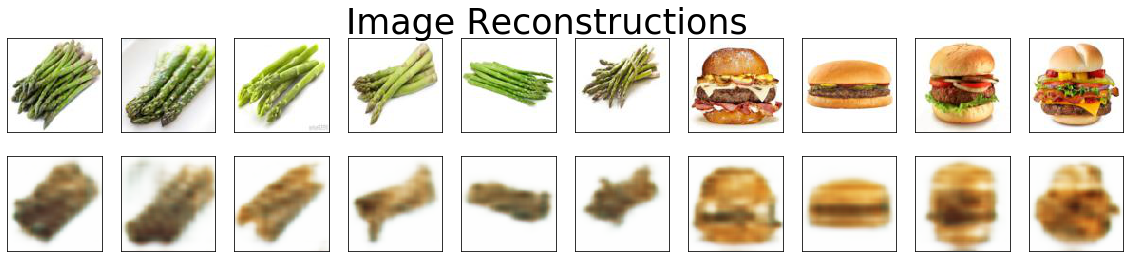

In [17]:
# Make reconstruction visualizations
if modelName in ["simpleAE", "convAE"]:
    print("Visualizing database image reconstructions...")
    imgs_train_reconstruct = model.decoder.predict(E_train)
    if modelName == "simpleAE":
        imgs_train_reconstruct = imgs_train_reconstruct.reshape((-1,) + shape_img_resize)
    plot_reconstructions(imgs_train, imgs_train_reconstruct,
                         #os.path.join(outDir, "{}_reconstruct.png".format(modelName)),
                         None,
                         range_imgs=[0, 255],
                         range_imgs_reconstruct=[0, 1])

In [12]:
# Fit kNN model on training images
print("Fitting k-nearest-neighbour model on training images...")
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(E_train_flatten)

Fitting k-nearest-neighbour model on training images...


NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

Visualizing t-SNE on training images...


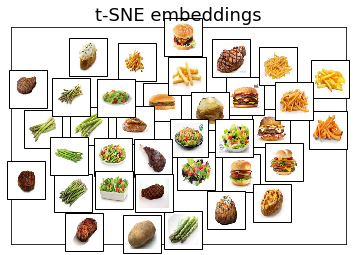

In [18]:
# Plot t-SNE visualization
print("Visualizing t-SNE on training images...")
outFile = os.path.join(outDir, "{}_tsne.png".format(modelName))
#plot_tsne(E_train_flatten, imgs_train, outFile)
plot_tsne(E_train_flatten, imgs_train, None)

In [ ]:
#Similar images are clustered together!